Tools

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
sns.set_style("darkgrid")

Clean-Up Data to fit the data schema I want to use to train models.

In [ ]:
# Load the CSV file
data = pd.read_csv('100k_Movies_dataset.csv')

# Delete unwanted columns
columns_to_delete = ['id', 'released_year', 'movie_link']
data = data.drop(columns_to_delete, axis=1)

# Remove rows with NaN values in the 'ratings' column
data = data.dropna(subset=['ratings'])

# Remove rows with unusable descriptions 
data.drop(data[data['Description'] == "#NAME?"].index, inplace=True)
data.drop(data[data['Description'] == "Add a Plot"].index, inplace=True)
data['Description'] = data['Description'].replace(r'\s*\.\.\.\s*See full summary.*', '', regex=True)

# Reorder the columns by moving 'ratings' to the end
cols = list(data.columns)
cols.remove('ratings')
cols.append('ratings')
data = data[cols]

out_file = 'Movie_Data.csv'
data.to_csv(out_file, index=False)

Unencoded Data

In [ ]:
data.head(10)

,title,runtime,genre,director,cast,Description,ratings
0,Coyote Ugly,100 min,"['Comedy', 'Drama', 'Music']",['David McNally'],"['PiperPerabo', 'AdamGarcia', 'JohnGoodman', '...","Aspiring songwriter Violet Sanford, after gett...",5.7
1,American Psycho,102 min,"['Crime', 'Drama', 'Horror']",['Mary Harron'],"['ChristianBale', 'JustinTheroux', 'JoshLucas'...",A wealthy New York City investment banking exe...,7.6
2,Gladiator,155 min,"['Action', 'Adventure', 'Drama']",['Ridley Scott'],"['RussellCrowe', 'JoaquinPhoenix', 'ConnieNiel...",A former Roman General sets out to exact venge...,8.5
3,Requiem for a Dream,102 min,['Drama'],['Darren Aronofsky'],"['EllenBurstyn', 'JaredLeto', 'JenniferConnell...",The drug-induced utopias of four Coney Island ...,8.3
4,Scary Movie,88 min,['Comedy'],['Keenen Ivory Wayans'],"['AnnaFaris', 'JonAbrahams', 'MarlonWayans', '...",A year after disposing of the body of a man th...,6.2
5,Memento,113 min,"['Mystery', 'Thriller']",['Christopher Nolan'],"['GuyPearce', 'Carrie-AnneMoss', 'JoePantolian...",A man with short-term memory loss attempts to ...,8.4
6,Snatch,104 min,"['Comedy', 'Crime']",['Guy Ritchie'],"['JasonStatham', 'BradPitt', 'StephenGraham', ...","Unscrupulous boxing promoters, violent bookmak...",8.3
7,Malèna,108 min,"['Drama', 'Romance', 'War']",['Giuseppe Tornatore'],"['MonicaBellucci', 'GiuseppeSulfaro', 'Luciano...","Amidst the war climate, a teenage boy discover...",7.4
8,X-Men,104 min,"['Action', 'Adventure', 'Sci-Fi']",['Bryan Singer'],"['PatrickStewart', 'HughJackman', 'IanMcKellen...",In a world where mutants (evolved super-powere...,7.3
9,Almost Famous,122 min,"['Adventure', 'Comedy', 'Drama']",['Cameron Crowe'],"['BillyCrudup', 'PatrickFugit', 'KateHudson', ...",A high-school boy in the early 1970s is given ...,7.9


Pre-processed ratings 

<Axes: >

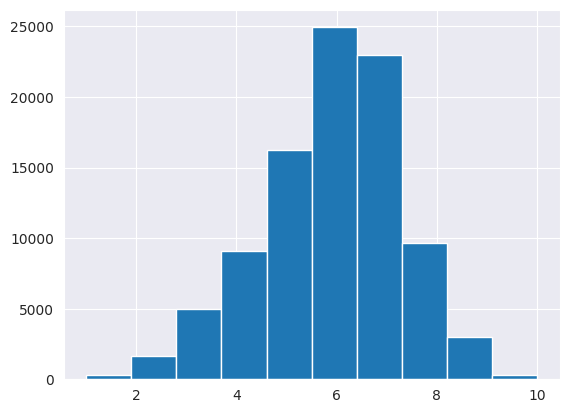

In [ ]:
data['ratings'].hist()

In [ ]:
print(data.describe())

            ratings
count  93195.000000
mean       5.850285
std        1.374956
min        1.000000
25%        5.000000
50%        6.000000
75%        6.800000
max       10.000000


Split the uneven data into bins to hold equal amount in each

---



In [ ]:
# Load the dataset
data = pd.read_csv('Movie_Data.csv')

# Set the number of samples per rating bin
samples_per_bin = 10000

# Split the dataset into separate DataFrames based on the rating bins
data['bins'] = pd.cut(data['ratings'], bins=[0, 4, 7, 10], labels=[1, 2, 3], include_lowest=True)

# Create a balanced dataset using groupby and sample methods
data_balanced = data.groupby('bins').apply(lambda x: x.sample(samples_per_bin, random_state=42)).reset_index(drop=True)

# Save the modified data to a new CSV file
out_file = 'bal_movie_Data.csv'
data_balanced.to_csv(out_file, index=False)



<Axes: >

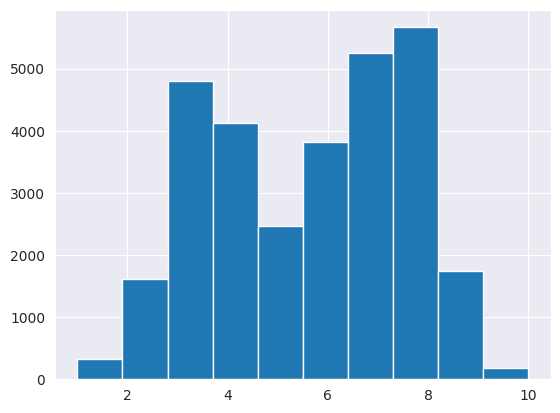

In [ ]:
data_balanced['ratings'].hist()

In [ ]:
print(data_balanced.describe())

            ratings
count  30000.000000
mean       5.576400
std        1.926903
min        1.000000
25%        3.800000
50%        5.900000
75%        7.300000
max       10.000000


Use a label encoder to encode the text into data the algorithms can digest (here we are using an encoder for the description as well)

In [ ]:
# Encode categorical variables
encoder = LabelEncoder()
data_balanced['title'] = encoder.fit_transform(data_balanced['title'])
data_balanced['genre'] = encoder.fit_transform(data_balanced['genre'])
data_balanced['director'] = encoder.fit_transform(data_balanced['director'])
data_balanced['cast'] = encoder.fit_transform(data_balanced['cast'])
data_balanced['runtime'] = encoder.fit_transform(data_balanced['runtime'])
data_balanced['Description'] = encoder.fit_transform(data_balanced['runtime'])

Split data into training and testing sets (No stratify)

In [ ]:
# Separate features (X) and target (y)
X_ = data_balanced.drop('ratings', axis=1)
X = X_.drop('bins', axis=1)
y = data_balanced['bins']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Logistic Regression:

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Train the Logistic Regression model
lr_model = LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
#lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix: \n", conf_matrix)


Accuracy:  0.4073333333333333
Confusion Matrix: 
 [[1423   76  503]
 [1125   61  810]
 [ 957   85  960]]


Naive Bayes:

In [ ]:
# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix: \n", confusion_matrix)



Accuracy:  0.3615
Confusion Matrix: 
 [[881 874 247]
 [749 846 401]
 [715 845 442]]


Split data into training and testing sets. Stratify by the bins to get a balanced sampled from each.

In [ ]:
# Separate features (X) and target (y)
X_ = data_balanced.drop('ratings', axis=1)
X = X_.drop('bins', axis=1)
y = data_balanced['bins']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Train the Logistic Regression model
lr_model = LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
#lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix: \n", conf_matrix)


Accuracy:  0.42533333333333334
Confusion Matrix: 
 [[1481   62  457]
 [1156   41  803]
 [ 907   63 1030]]


In [ ]:
# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix: \n", confusion_matrix)



Accuracy:  0.3585
Confusion Matrix: 
 [[836 784 380]
 [727 774 499]
 [668 791 541]]


Use the GridsearchCV function to tune the hyperparameters of the better performing algorithm. This finds the best values for the 'C' and 'solver' parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
              'C': [0.1, 1, 10, 100]}
lr_model = LogisticRegression(multi_class='ovr', max_iter=1000)
cv = GridSearchCV(lr_model, parameters)
cv.fit(X_train, y_train)

# The best parameters after tuning
print(cv.best_params_)

best_model = cv.best_estimator_

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optim

{'C': 0.1, 'solver': 'newton-cg'}


Train the Logistic Regression algorithm with the optomized parameters found by the grid search.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", conf_matrix)

Accuracy:  0.428
Confusion Matrix: 
 [[1537    2  461]
 [1186    1  813]
 [ 960   10 1030]]


Use a vectorizer for Description column instead of an encoder.

In [ ]:
more_data = pd.read_csv('bal_movie_Data.csv')

enc = LabelEncoder()

more_data['title'] = enc.fit_transform(more_data['title'])
more_data['genre'] = enc.fit_transform(more_data['genre'])
more_data['director'] = enc.fit_transform(more_data['director'])
more_data['cast'] = enc.fit_transform(more_data['cast'])
more_data['runtime'] = enc.fit_transform(more_data['runtime'])


# Convert the description column with the use of TF-IDF and concatenate to original movie data
vect = TfidfVectorizer(max_features=1000, stop_words='english')
description_tfidf = vect.fit_transform(more_data['Description'])
description_tfidf_df = pd.DataFrame(description_tfidf.toarray(), columns=vect.get_feature_names_out())
more_data = pd.concat([more_data.drop('Description', axis=1), description_tfidf_df], axis=1)

# Separate features (X) and target (y)
X_ = more_data.drop('ratings', axis=1)
X = X_.drop('bins', axis=1)
y = more_data['bins']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train Logistic Regression model with vectorized Description column (no stratify).

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Train the Logistic Regression model
lr_model = LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
#lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix: \n", conf_matrix)

Accuracy:  0.4075
Confusion Matrix: 
 [[1423   76  503]
 [1125   62  809]
 [ 957   85  960]]


Stratify training and testing data

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Train Logistic Regression model with vetorized Description column and stratified data.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Train the Logistic Regression model
lr_model = LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
#lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix: \n", conf_matrix)

Accuracy:  0.4255
Confusion Matrix: 
 [[1481   62  457]
 [1156   41  803]
 [ 907   62 1031]]


Visual representaion of model accuracy through different data preprocing

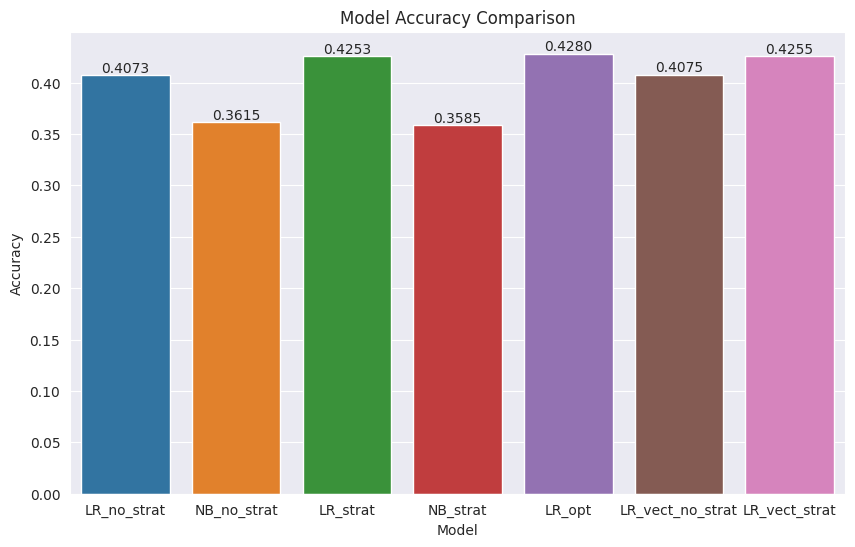

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy scores
models = ['LR_no_strat', 'NB_no_strat', 'LR_strat', 'NB_strat', 'LR_opt', 'LR_vect_no_strat', 'LR_vect_strat']
accuracy_scores = [0.4073, 0.3615, 0.4253, 0.3585, 0.428, 0.4075, 0.4255]

# Bar chart
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=models, y=accuracy_scores)

# Add accuracy scores on top of the bars
for bar, score in zip(bars.patches, accuracy_scores):
    bars.text(bar.get_x() + bar.get_width() / 2., bar.get_height(), 
              f'{score:.4f}', ha='center', va='bottom')

plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

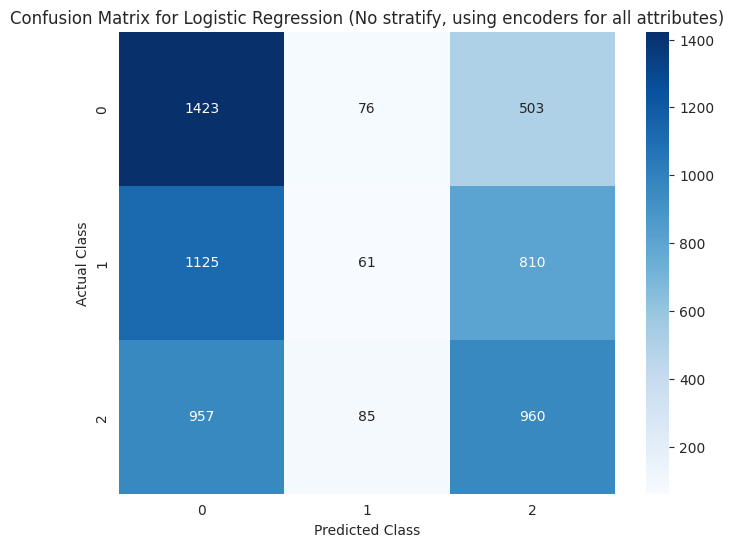

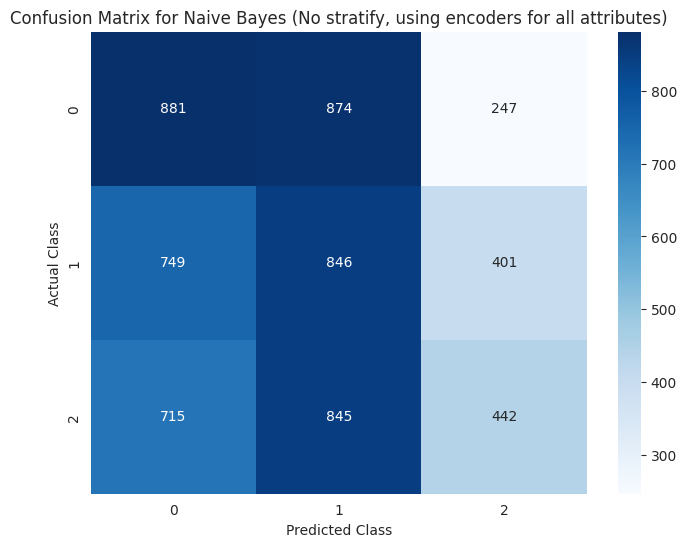

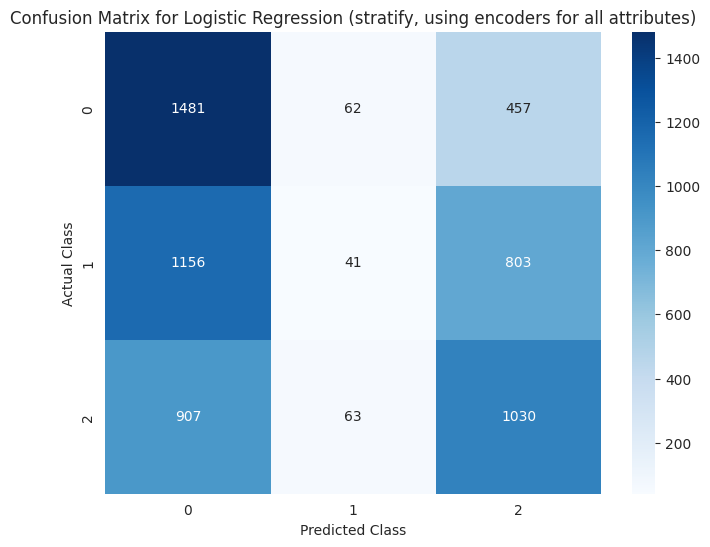

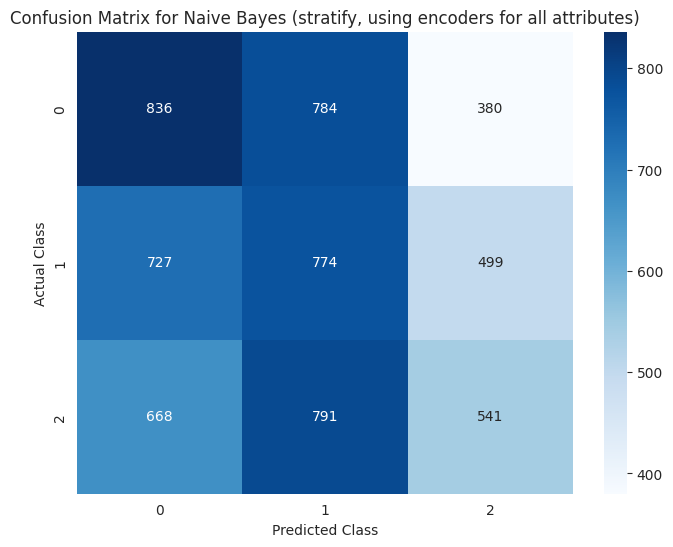

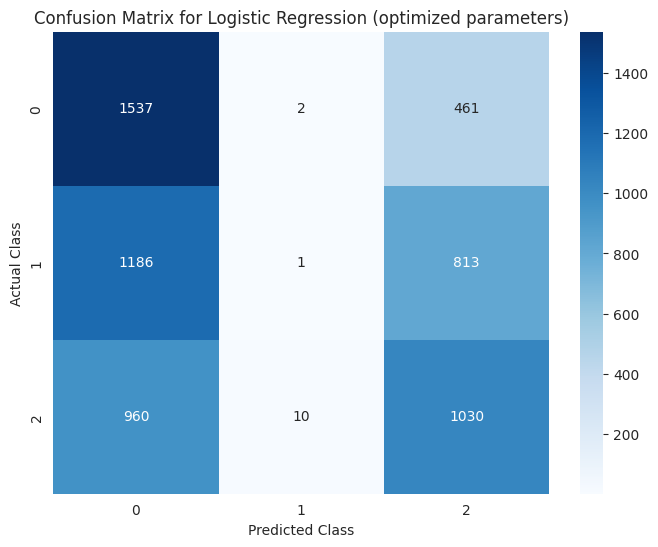

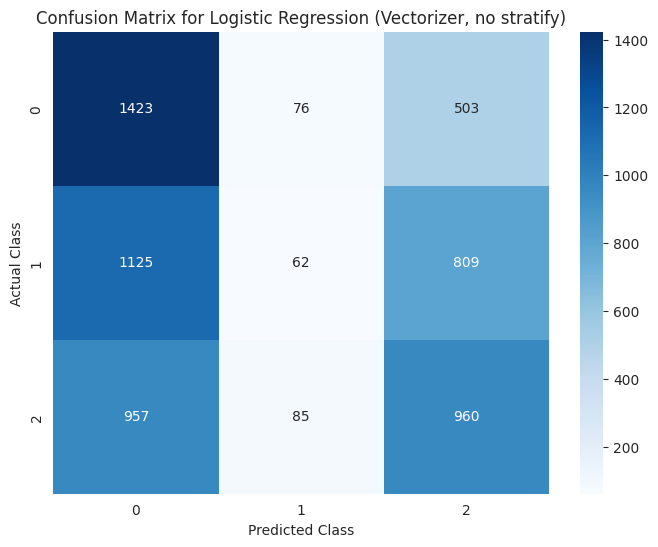

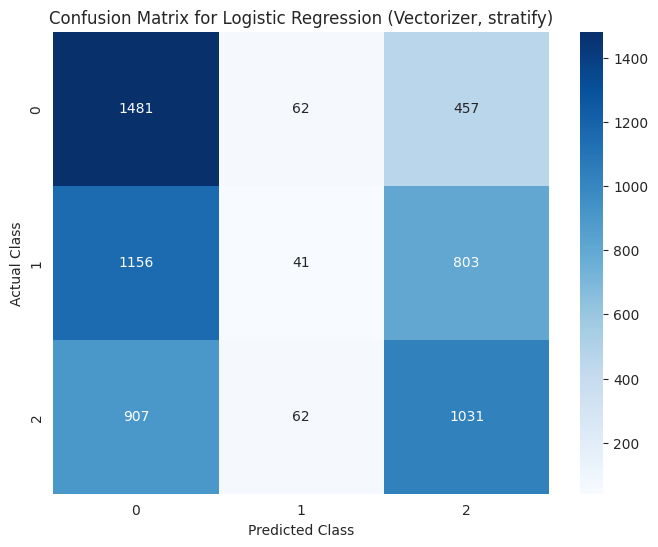

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define confusion matrices
cm_LR_no_strat = [[1423, 76, 503], [1125, 61, 810], [957, 85, 960]]
cm_NB_no_strat = [[881, 874, 247], [749, 846, 401], [715, 845, 442]]
cm_LR_strat = [[1481, 62, 457], [1156, 41, 803], [907, 63, 1030]]
cm_NB_strat = [[836, 784, 380], [727, 774, 499], [668, 791, 541]]
cm_LR_opt = [[1537, 2, 461], [1186, 1, 813], [960, 10, 1030]]
cm_LR_vect_no_strat = [[1423, 76, 503], [1125, 62, 809], [957, 85, 960]]
cm_LR_vect_strat = [[1481, 62, 457], [1156, 41, 803], [907, 62, 1031]]

# List of confusion matrices and corresponding titles
confusion_matrices = [cm_LR_no_strat, cm_NB_no_strat, cm_LR_strat, cm_NB_strat, cm_LR_opt, cm_LR_vect_no_strat, cm_LR_vect_strat]
titles = [
    'Logistic Regression (No stratify, using encoders for all attributes)',
    'Naive Bayes (No stratify, using encoders for all attributes)',
    'Logistic Regression (stratify, using encoders for all attributes)',
    'Naive Bayes (stratify, using encoders for all attributes)',
    'Logistic Regression (optimized parameters)',
    'Logistic Regression (Vectorizer, no stratify)',
    'Logistic Regression (Vectorizer, stratify)'
]

# Generate heatmaps for all confusion matrices
for i in range(len(confusion_matrices)):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for ' + titles[i])
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()
